In [1]:
import numpy as np
import pandas as pd
import numpy.ma as ma
import h5py
import scipy.io
import os
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy import stats
from sklearn.preprocessing import StandardScaler
from numba import njit
from sklearn import linear_model
from sklearn.metrics import r2_score
import warnings
from sklearn.exceptions import ConvergenceWarning
from scipy.stats import pearsonr, bootstrap, BootstrapMethod
from statsmodels.stats.multitest import multipletests

# Data loading

In [2]:
marker_labels = np.load('marker_labels.npy')
marker_labels[0] = 'C7' #rename marker label
n_markers = len(marker_labels)

clusters = np.array([1,1,1,2,2,2,2,3,4,3,4,5,5,6,6,5,5,6,6])

for kc in np.unique(clusters):
    print( marker_labels[clusters==kc])

['C7' 'MA Shoulder' 'LA Shoulder']
['MA-ASI' 'MA-PSI' 'LA-ASI' 'LA-PSI']
['MA Elbow' 'MA Hand']
['LA Elbow' 'LA Hand']
['MA Knee' 'MA Ankle' 'MA Calc' 'MA Toe']
['LA Knee' 'LA Ankle' 'LA Calc' 'LA Toe']


In [3]:
# Data extraction - correlation metrics
f=h5py.File('corr_matrices_3planes.h5','r')
labels = list(f.keys())
C_a_subj_cond=[]
subj_cond_labels=[]
for kl,l in enumerate(labels):
    fc = f[l]
    C_a = np.array(fc['C_a_trials'])
    C_a[:,np.arange(n_markers),np.arange(n_markers),:]=0
    C_a_subj_cond.append(C_a)
    subj_cond_labels.append(l.split(';'))
    
f.close()
subj_cond_labels=np.array(subj_cond_labels)

In [4]:
# Whole body  aggregation

cwb = []
# Define cluster sets 
cluster_sets = [[1,2,3,4,5,6]]

# Get indices 
indices_clusters = [np.concatenate([np.where(clusters == c)[0] for c in clist]) 
                    for clist in cluster_sets]

# Loop over cluster sets
for idx, idx_cluster in enumerate(indices_clusters):
    cwb_cond_trial = []
    for k in range(len(C_a_subj_cond)):
        cwb_trial = []
        for i in range(len(C_a_subj_cond[k])):
            submat = np.abs(C_a_subj_cond[k][i]).mean(axis=2)[idx_cluster, :][:, idx_cluster]
            cwbmean = np.triu(submat, k=1).mean()
            cwb_trial.append(cwbmean) 
        cwb_cond_trial.append(np.hstack(cwb_trial).mean())
    
    cwb.append(np.hstack(cwb_cond_trial))

var_wb = list()
var_wb.append('Whole body')

Xwb = np.array(cwb).T

In [5]:
# Segments definition

indices_clusters=[]
for km in np.unique(clusters):
    indices_clusters.append(np.where(clusters==km)[0])

In [6]:
# Segment pairs

cpairs=[]
var_labels=[]

for kc1 in range(len(indices_clusters)):
    for kc2 in range(kc1+1,len(indices_clusters)):
        c_cond_trial = []
        for k in range(len(C_a_subj_cond)):
            c_trial=[]
            for i in range(len(C_a_subj_cond[k])):
                cmean = np.abs(C_a_subj_cond[k][i]).mean(axis=2)[indices_clusters[kc1],:][:,indices_clusters[kc2]].mean()
                c_trial.append(cmean)
            c_cond_trial.append(np.hstack(c_trial).mean())  
        cpairs.append(np.hstack(c_cond_trial))
        var_labels.append([kc1,kc2])

print(var_labels)

var_short = list()
var_short.append('Trunk-Pelvis')
var_short.append('Trunk-MA UL')
var_short.append('Trunk-LA UL')
var_short.append('Trunk-MA LL')
var_short.append('Trunk-LA LL')
var_short.append('Pelvis-MA UL')
var_short.append('Pelvis-LA UL')
var_short.append('Pelvis-MA LL')
var_short.append('Pelvis-LA LL')
var_short.append('MA UL-LA UL')
var_short.append('MA UL-MA LL')
var_short.append('MA UL-LA LL')
var_short.append('LA UL-MA LL')
var_short.append('LA UL-LA LL')
var_short.append('MA LL-LA LL')

Xps = np.array(cpairs).T

[[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]


## FIGURE 1B

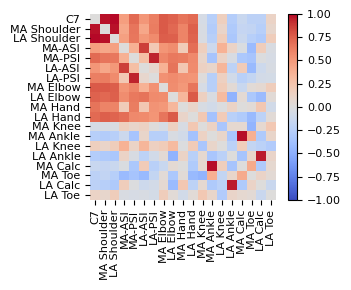

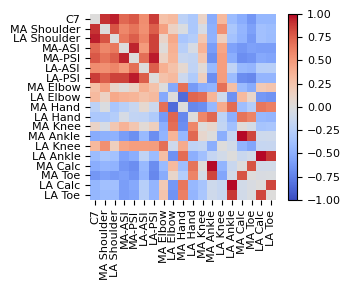

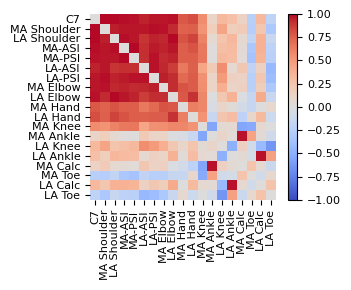

In [7]:
## Data visualization

for kd in range(3):
    plt.figure(figsize=(4, 3))  
    im = plt.imshow(C_a_subj_cond[0][0][:,:,kd],vmax=1,vmin=-1,cmap='coolwarm', interpolation='nearest')
    # --- Colorbar ---
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)
    # --- Axis labels ---
    plt.xticks(np.arange(len(marker_labels)), marker_labels, rotation=90, fontsize=8)
    plt.yticks(np.arange(len(marker_labels)), marker_labels, rotation=0, fontsize=8)
    
    # --- Grid & frame styling ---
    plt.gca().set_aspect('equal', adjustable='box')  # make squares actually square
    sns.despine(left=True, bottom=True)
    plt.grid(False)
    # plt.title("OFF DOPA", fontsize=9, fontweight='normal', pad=2)
    # --- Optional title (minimal style for journals) ---
    # plt.title("Coarse Connectivity Matrix", fontsize=10, pad=5)
    
    # --- Tight layout for export ---
    plt.tight_layout()
    os.makedirs('Figures/Main/Figure 1', exist_ok=True)
    plt.savefig(f"Figures/Main/Figure 1/Subpane 1B_C_example_{kd}.png", 
        dpi=1000, bbox_inches="tight", facecolor = 'white')
    plt.show()

## FIGURE 1C

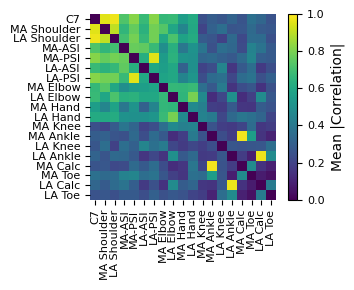

In [8]:
import seaborn as sns

a = np.abs(C_a_subj_cond[0][0]).mean(axis=2)

plt.figure(figsize=(4, 3))  # increase dpi for crisp journal figures

# --- Plot ---
im = plt.imshow(a, vmin=0, vmax=1, cmap='viridis', interpolation='nearest')

# --- Colorbar ---
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("Mean |Correlation|", fontsize=10)
cbar.ax.tick_params(labelsize=8)

# --- Axis labels ---
plt.xticks(np.arange(len(a)), marker_labels, rotation=90, fontsize=8)
plt.yticks(np.arange(len(a)), marker_labels, rotation=0, fontsize=8)

# --- Grid & frame styling ---
plt.gca().set_aspect('equal', adjustable='box')  # make squares actually square
sns.despine(left=True, bottom=True)
plt.grid(False)
# plt.title("OFF DOPA", fontsize=9, fontweight='normal', pad=2)
# --- Optional title (minimal style for journals) ---
# plt.title("Coarse Connectivity Matrix", fontsize=10, pad=5)

# --- Tight layout for export ---
plt.tight_layout()
os.makedirs('Figures/Main/Figure 1', exist_ok=True)
plt.savefig(f"Figures/Main/Figure 1/Subpane 1C_MAV_matrix_example.png", 
    dpi=1000, bbox_inches="tight", facecolor = 'white')
   
plt.show()

In [11]:
# Load clinical data

file_path = '_df_clinical.xlsx'  # Update if needed
xls = pd.ExcelFile(file_path)
df = xls.parse(xls.sheet_names[0])
vars_clinical = [col for col in df.columns if col not in ['Participant','Condition']]
clinical_data = {var: df[var].values for var in vars_clinical}
lookup_clinical_data = np.column_stack((df['Condition'],df['Participant']))
clinical_data_fog = clinical_data[vars_clinical[-1]]
clinical_data_updrs = clinical_data[vars_clinical[2]]
clinical_data_gabs = clinical_data[vars_clinical[-2]]

In [12]:
parts_pre = np.unique(subj_cond_labels[:,1][subj_cond_labels[:,0]=='OFF DOPA'])
print(parts_pre)

['PD01' 'PD02' 'PD03' 'PD05' 'PD07' 'PD08' 'PD09' 'PD10' 'PD11' 'PD12'
 'PD13' 'PD14' 'PD15' 'PD16' 'PD17' 'PD18']


In [13]:
# Variables initialization

Xwb_on_scores= np.zeros((len(parts_pre),Xwb.shape[1]))
Xwb_off_scores= np.zeros((len(parts_pre),Xwb.shape[1]))
Xwb_on_dbs_scores = np.zeros((len(parts_pre),Xwb.shape[1]))
Xwb_off_dbs_scores = np.zeros((len(parts_pre),Xwb.shape[1]))

Xp_on_scores= np.zeros((len(parts_pre),Xps.shape[1]))
Xp_off_scores= np.zeros((len(parts_pre),Xps.shape[1]))
Xp_on_dbs_scores = np.zeros((len(parts_pre),Xps.shape[1]))
Xp_off_dbs_scores = np.zeros((len(parts_pre),Xps.shape[1]))

fog_post = np.zeros(len(parts_pre))
fog_pre = np.zeros(len(parts_pre))
updrs_on = np.zeros(len(parts_pre))
updrs_off = np.zeros(len(parts_pre))
updrs_dbs = np.zeros(len(parts_pre))
gabs_on = np.zeros(len(parts_pre))
gabs_off = np.zeros(len(parts_pre))
gabs_dbs = np.zeros(len(parts_pre))
updrs_off_dbs = np.zeros(len(parts_pre))
gabs_off_dbs = np.zeros(len(parts_pre))

for kp,part in enumerate(parts_pre):
    sel_kin_on = np.all(subj_cond_labels==['ON DOPA',part],axis=1)
    Xwb_on_scores[kp] = Xwb[sel_kin_on]
    Xp_on_scores[kp] = Xps[sel_kin_on]

    sel_clin_on = np.all(lookup_clinical_data==['ON DOPA',part],axis=1)
    updrs_on[kp] = clinical_data_updrs[sel_clin_on][0]
    gabs_on[kp] = clinical_data_gabs[sel_clin_on][0]

    sel_kin_off = np.all(subj_cond_labels==['OFF DOPA',part],axis=1)
    Xwb_off_scores[kp] = Xwb[sel_kin_off]
    Xp_off_scores[kp] = Xps[sel_kin_off]

    sel_clin_off = np.all(lookup_clinical_data==['OFF DOPA',part],axis=1)
    fog_pre[kp] = clinical_data_fog[sel_clin_off][0]
    updrs_off[kp] = clinical_data_updrs[sel_clin_off][0]
    gabs_off[kp] = clinical_data_gabs[sel_clin_off][0]

    sel_kin_on_dbs = np.all(subj_cond_labels==['ON DBS',part],axis=1)
    Xwb_on_dbs_scores[kp] = Xwb[sel_kin_on_dbs]
    Xp_on_dbs_scores[kp] = Xps[sel_kin_on_dbs]
    
    sel_clin_dbs = np.all(lookup_clinical_data==['ON DBS',part],axis=1)
    updrs_dbs[kp] = clinical_data_updrs[sel_clin_dbs][0]
    gabs_dbs[kp] = clinical_data_gabs[sel_clin_dbs][0]

    sel_kin_off_dbs = np.all(subj_cond_labels==['OFF DBS',part],axis=1)
    Xwb_off_dbs_scores[kp] = Xwb[sel_kin_off_dbs]
    Xp_off_dbs_scores[kp] = Xps[sel_kin_off_dbs]

    sel_clin_off_dbs = np.all(lookup_clinical_data==['OFF DBS',part],axis=1)
    fog_post[kp] = clinical_data_fog[sel_clin_off_dbs][0]
    updrs_off_dbs[kp] = clinical_data_updrs[sel_clin_off_dbs][0]
    gabs_off_dbs[kp] = clinical_data_gabs[sel_clin_off_dbs][0]

## FIGURE 1E

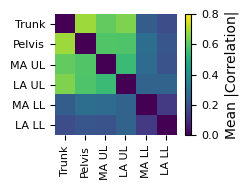

In [17]:
idx_i,idx_j = np.triu_indices(len(indices_clusters),1)
C_coarse = np.zeros((len(indices_clusters),len(indices_clusters)))

C_coarse[idx_i,idx_j] = Xp_off_scores[1] 
C_coarse[idx_j,idx_i] = Xp_off_scores[1] 
# --- High-quality figure setup ---
plt.figure(figsize=(3, 2))  

# --- Plot ---
im = plt.imshow(C_coarse, vmin=0, vmax=0.8, cmap='viridis', interpolation='nearest')

# --- Colorbar ---
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("Mean |Correlation|", fontsize=10)
cbar.ax.tick_params(labelsize=8)

# --- Axis labels ---
labels = ['Trunk','Pelvis','MA UL','LA UL','MA LL','LA LL']
plt.xticks(np.arange(len(C_coarse)), labels, rotation=90, fontsize=8)
plt.yticks(np.arange(len(C_coarse)), labels, rotation=0, fontsize=8)

# --- Grid & frame styling ---
plt.gca().set_aspect('equal', adjustable='box')  # make squares actually square
sns.despine(left=True, bottom=True)
plt.grid(False)
# plt.title("OFF DOPA", fontsize=9, fontweight='normal', pad=2)
# --- Optional title (minimal style for journals) ---
# plt.title("Coarse Connectivity Matrix", fontsize=10, pad=5)

plt.tight_layout()
os.makedirs('Figures/Main/Figure 1', exist_ok=True)
plt.savefig(f"Figures/Main/Figure 1/Subpane 1E_coarse_matrix_example.png", 
    dpi=1000, bbox_inches="tight", facecolor = 'white')
   
plt.show()